In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import glob

In [2]:
train_path = '../input/cifar/train/*.png'
test_path = '../input/cifar/test/*.png'

train_imgs = glob.glob(train_path)
test_imgs = glob.glob(test_path)
labels = []
with open("../input/cifar/labels.txt", 'r') as f:
    labels = f.readlines()
label_idx_dict = {label.replace('\n',''):idx for idx, label in enumerate(labels)}
label_idx_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [3]:
import torch
import torchvision
import PIL
import time

In [4]:
transform_dict = {
    'train':torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test':torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [5]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self,img_path, label_idx_dict,transform=None):
        super(CIFAR10Dataset,self).__init__()
        self.img_path = img_path
        self.label_idx_dict = label_idx_dict
        self.transform = transform
        
    def __getitem__(self,idx):
        img_p = self.img_path[idx]
        img = PIL.Image.open(img_p)
        label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
        label_idx = self.label_idx_dict[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_idx
        
    def __len__(self):
        return len(self.img_path)

In [6]:
train_ds = CIFAR10Dataset(train_imgs, label_idx_dict, transform_dict['train'])
test_ds = CIFAR10Dataset(test_imgs, label_idx_dict, transform_dict['test'])

In [7]:
batch_size = 1024
num_epoch = 200

In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
net = torchvision.models.mobilenet_v2(pretrained=True)
net.classifier[1] = torch.nn.Linear(1280,10)
model_name = net.__class__.__name__
net

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch/5)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net.to(device)

In [14]:
hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
print("MODEL: {}".format(model_name))
prints_list = []
for epoch in range(num_epoch):
    since = time.time()
    epoch_loss = 0.
    epoch_corrects = 0.
    epoch_imgs = 0.
    
    for batch in train_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(imgs)
        
        optimizer.zero_grad()
        outputs=net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * imgs.size(0)
        epoch_corrects += sum(outputs.argmax(1)==labels)
        
    l = epoch_loss / epoch_imgs
    a = epoch_corrects / epoch_imgs

    hist['loss'].append(l)
    hist['acc'].append(a)
    
    print_text = "Epoch {}: Loss: {:.4f} Acc: {:.4} Time: {}".format(epoch+1,l, a, time.time()-since)
    prints_list.append(print_text)
    print(print_text)
    
    
    net.eval()
    val_loss = 0.
    val_corrects = 0.
    val_imgs = 0.
    
    for batch in test_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        val_imgs += len(labels)
        
        with torch.no_grad():
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()*imgs.size(0)
            val_corrects += sum(outputs.argmax(1) == labels)
            
    l = val_loss / val_imgs
    a = val_corrects / val_imgs
    cur_lr = scheduler.optimizer.param_groups[0]['lr']
    
    hist['val_loss'].append(l)
    hist['val_acc'].append(a)
    print_text = "Val: Loss: {:.4f} Acc: {:.4f} lr: {:.6f}".format(l, a, cur_lr)
    prints_list.append(print_text)
    print(print_text)
    
    scheduler.step()

MODEL: MobileNetV2
Epoch 1: Loss: 1.7804 Acc: 0.3724 Time: 126.54249382019043
Val: Loss: 1.3329 Acc: 0.5249 lr: 0.000050
Epoch 2: Loss: 1.1016 Acc: 0.6087 Time: 49.6338574886322
Val: Loss: 1.0268 Acc: 0.6373 lr: 0.000050
Epoch 3: Loss: 0.9064 Acc: 0.6774 Time: 48.96470522880554
Val: Loss: 0.9320 Acc: 0.6710 lr: 0.000050
Epoch 4: Loss: 0.7923 Acc: 0.7205 Time: 49.27473163604736
Val: Loss: 0.8768 Acc: 0.6948 lr: 0.000049
Epoch 5: Loss: 0.7114 Acc: 0.7493 Time: 48.83849239349365
Val: Loss: 0.8404 Acc: 0.7070 lr: 0.000049
Epoch 6: Loss: 0.6420 Acc: 0.7751 Time: 49.83592629432678
Val: Loss: 0.8332 Acc: 0.7163 lr: 0.000048
Epoch 7: Loss: 0.5806 Acc: 0.798 Time: 50.0519003868103
Val: Loss: 0.8035 Acc: 0.7286 lr: 0.000047
Epoch 8: Loss: 0.5266 Acc: 0.8181 Time: 51.42412757873535
Val: Loss: 0.7998 Acc: 0.7313 lr: 0.000046
Epoch 9: Loss: 0.4740 Acc: 0.8372 Time: 49.655234575271606
Val: Loss: 0.8141 Acc: 0.7293 lr: 0.000045
Epoch 10: Loss: 0.4296 Acc: 0.8539 Time: 48.77935266494751
Val: Loss: 0.8

Epoch 82: Loss: 0.0004 Acc: 1.0 Time: 48.5335328578949
Val: Loss: 2.1229 Acc: 0.7303 lr: 0.000050
Epoch 83: Loss: 0.0004 Acc: 1.0 Time: 48.93712830543518
Val: Loss: 2.1375 Acc: 0.7306 lr: 0.000050
Epoch 84: Loss: 0.0004 Acc: 1.0 Time: 49.54624795913696
Val: Loss: 2.1503 Acc: 0.7313 lr: 0.000049
Epoch 85: Loss: 0.0004 Acc: 1.0 Time: 48.16922855377197
Val: Loss: 2.1638 Acc: 0.7311 lr: 0.000049
Epoch 86: Loss: 0.0003 Acc: 1.0 Time: 48.798990964889526
Val: Loss: 2.1761 Acc: 0.7313 lr: 0.000048
Epoch 87: Loss: 0.0003 Acc: 1.0 Time: 49.02536654472351
Val: Loss: 2.1869 Acc: 0.7314 lr: 0.000047
Epoch 88: Loss: 0.0003 Acc: 1.0 Time: 48.44999074935913
Val: Loss: 2.1986 Acc: 0.7316 lr: 0.000046
Epoch 89: Loss: 0.0003 Acc: 1.0 Time: 48.411229372024536
Val: Loss: 2.2088 Acc: 0.7307 lr: 0.000045
Epoch 90: Loss: 0.0003 Acc: 1.0 Time: 46.313934087753296
Val: Loss: 2.2184 Acc: 0.7307 lr: 0.000044
Epoch 91: Loss: 0.0002 Acc: 1.0 Time: 44.81241178512573
Val: Loss: 2.2287 Acc: 0.7312 lr: 0.000043
Epoch 92

Epoch 164: Loss: 0.0000 Acc: 1.0 Time: 49.317909955978394
Val: Loss: 2.6554 Acc: 0.7322 lr: 0.000049
Epoch 165: Loss: 0.0000 Acc: 1.0 Time: 50.70113754272461
Val: Loss: 2.6652 Acc: 0.7322 lr: 0.000049
Epoch 166: Loss: 0.0000 Acc: 1.0 Time: 48.23629403114319
Val: Loss: 2.6753 Acc: 0.7324 lr: 0.000048
Epoch 167: Loss: 0.0000 Acc: 1.0 Time: 49.93720245361328
Val: Loss: 2.6828 Acc: 0.7324 lr: 0.000047
Epoch 168: Loss: 0.0000 Acc: 1.0 Time: 49.33227229118347
Val: Loss: 2.6923 Acc: 0.7329 lr: 0.000046
Epoch 169: Loss: 0.0000 Acc: 1.0 Time: 48.46073532104492
Val: Loss: 2.6997 Acc: 0.7324 lr: 0.000045
Epoch 170: Loss: 0.0000 Acc: 1.0 Time: 49.09022760391235
Val: Loss: 2.7074 Acc: 0.7330 lr: 0.000044
Epoch 171: Loss: 0.0000 Acc: 1.0 Time: 48.56421637535095
Val: Loss: 2.7154 Acc: 0.7325 lr: 0.000043
Epoch 172: Loss: 0.0000 Acc: 1.0 Time: 50.15901160240173
Val: Loss: 2.7216 Acc: 0.7324 lr: 0.000041
Epoch 173: Loss: 0.0000 Acc: 1.0 Time: 49.76499128341675
Val: Loss: 2.7278 Acc: 0.7325 lr: 0.000040

TypeError: write() argument must be str, not list

In [15]:
with open('mobv2_outputs.txt','w') as fw:
    fw.write(str(prints_list))

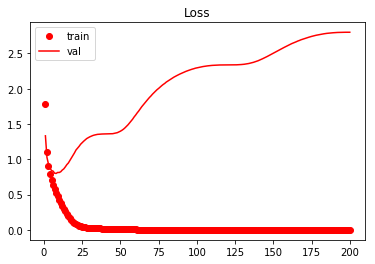

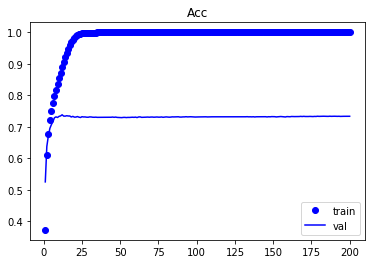

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, num_epoch+1)

plt.title('Loss')
plt.plot(epochs, hist['loss'],'ro', label='train')
plt.plot(epochs, hist['val_loss'], 'r',label='val')
plt.legend()
plt.show()
# plt.savefig('./mobv2_loss.png')

plt.figure()
plt.title('Acc')
plt.plot(epochs, hist['acc'], 'bo', label='train')
plt.plot(epochs, hist['val_acc'], 'b', label='val')
plt.legend()
plt.show()
# plt.savefig('./mobv2_acc.png')

## Discussion
Optimizer: Adam  

**Situation**:  
MobileNetv2 doesn't learn anything until 30 epochs in the first try(batch_size=1024, T_max=num_epoch/2, **lr=1e-3** )
But, in the second try(batch_size=5096), model learns a bit. 
Again, if batch_size=1024, the model doesn't learn anything.

Possible Causes:

1. T_max = num_epoch/2 causes this bad situation...? -> model stuck in the bad local optima.
2. Something wrong with code...?
3. lr=1e-3 is too big...?
4. lr=1e-3 is too small...?
5. Cosine Annealing LRScheduler should work with SGD as the original paper...? -> CosineAnnealingLR doesn't go well with Adam...?

Experiments:

1. T_max = num_epoch
2. ResNet50 instead of MobileNetv2
3. 
  * T_max = num_epoch/10 == 20
  * **lr=5e-5** 
4. Init lr=1e-1

Results:

1. Nothing happens.(Still doesn't learn)
2. ResNet50 Learns -> Code is fine...
3. 
  * Nothing happens.
  * **MobileNetv2 Learns!!**  
    Epoch 93: Loss: 0.0002 Acc: 1.0 Time: 48.925941944122314  
    Val: Loss: 2.3194 Acc: 0.7276 lr: 0.000028  
4. Nothing happens